In [ ]:
import laminoAlign as lam
from laminoAlign.plotting import plotImage

import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
import warnings
import os

warnings.filterwarnings("ignore", category=np.ComplexWarning)
plt.rcParams['image.cmap'] = 'bone'

# Select which GPU to use
cp.cuda.Device(0).use()

In [16]:
# Specify saveFolder (where data will be saved to)
saveFolder = '/some/file/path/'
# Specify location of config file
configFileName = 'config_cSAXSe18044.ini'
configPath = os.path.join(os.getcwd(), configFileName)
# Create saveFolder if it doesn't exist
if not os.path.isdir(saveFolder):
    os.makedirs(saveFolder)

In [ ]:
# Read in the configuration file
config = lam.read.getConfig(configPath)

In [3]:
# Read in the configuration file
config = lam.read.getConfig(configPath)
# Create the object that handles finding filepaths and loading data
fileReader = lam.read.fileReader(config)
# Initialize the data object
data = lam.data.data(
    config,
    fileReader)
data.configPath = configPath
# Indicate where data will be saved
lam.data.data.setFolders(data, parentFolder=saveFolder)

Loading projections into list...
32.9947 s  Loading projections into list...Completed


Single Frame Size: (1923, 1518) 
Number of Frames: 750


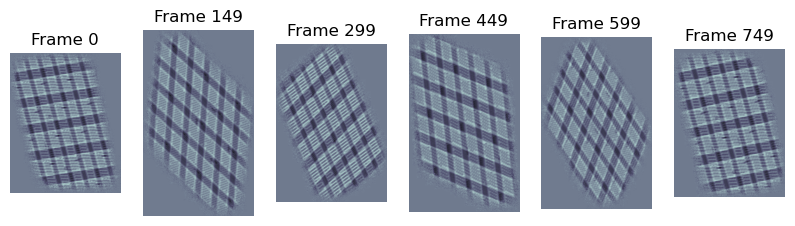

In [4]:
# Show a few of the loaded projections
data.plotSamples(data.stackObject, np.angle, N=6)

getWeightsFromPositions time: 32.11792492866516 s
Fixing stack dimensions...
7.0788 s  Fixing stack dimensions...Completed
Converting list to array...
4.7116 s  Converting list to array..Completed
Fixing stack dimensions...
4.3816 s  Fixing stack dimensions...Completed
Converting list to array...
2.5034 s  Converting list to array..Completed
Single Frame Size: (2368, 1600) 
Number of Frames: 8


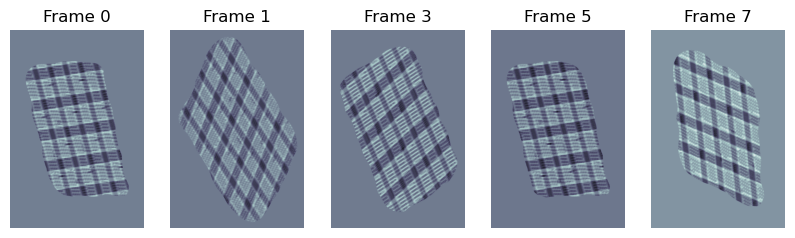

Single Frame Size: (2368, 1600) 
Number of Frames: 8


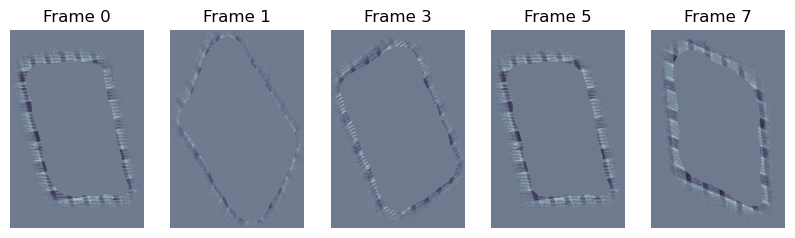

In [5]:
# - Use scan position data to get weights that indicate the sample region
# - The weights are stored in variable "weightSino"
lam.data.data.getWeightsFromPositions(data)
# - Crop/pad each of the projection and weights so that they are the same size
# - Then convert from list to array
lam.data.data.equalizeStackSize(data)
# - Show some plots of the weights*projection to check that the weights calculation was good
data.plotSamples(np.angle(data.stackObject[::100])*data.weightSino[::100])
# - Also show the regions that are excluded by the weights
data.plotSamples(np.angle(data.stackObject[::100]) *
                 (data.weightSino[0].max() - data.weightSino[::100]))

Single Frame Size: (1600, 2368) 
Number of Frames: 750


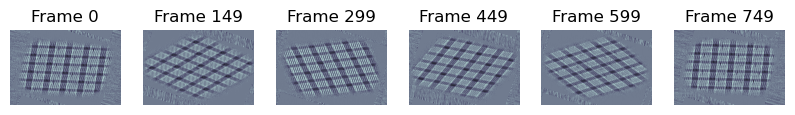

Single Frame Size: (1600, 2368) 
Number of Frames: 750


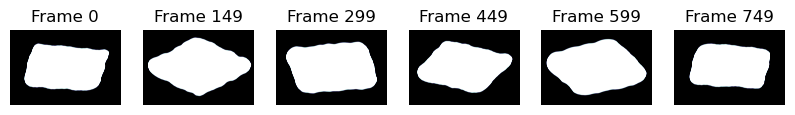

In [7]:
# Remove unwanted tilt and skew from the projections and weights -- the tilt and skew are pulled from the
# values in the config file.
lam.data.data.removeTiltAndSkew(data)
# Check that the data looks reasonable
data.plotSamples(data.stackObject, np.angle, N=6)
data.plotSamples(data.weightSino, N=6)

iteration 1/1


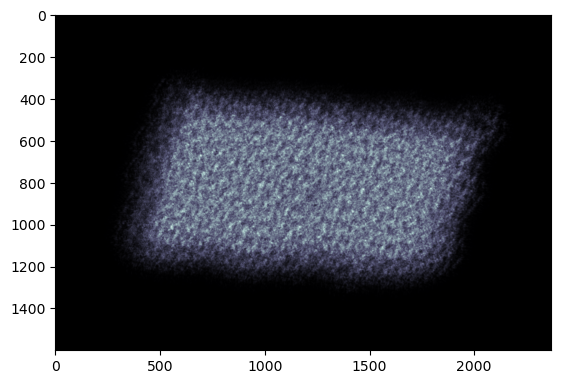

In [8]:
# Get the illumination at each point on the first
# Not extremely important, only used in cross-correlation alignment.
# If there is trouble with this function, you should be able to just replace
# data.illumSum with an array of 1s that is the size of the stackObject
lam.data.data.getIllumSum(data)
plotImage(data.illumSum)
plt.show()

Cross-correlation ROI: 
 - Vertical: 320 to 1279 
 - Horizontal: 704 to 1663
Single Frame Size: (1600, 2368) 
Number of Frames: 750


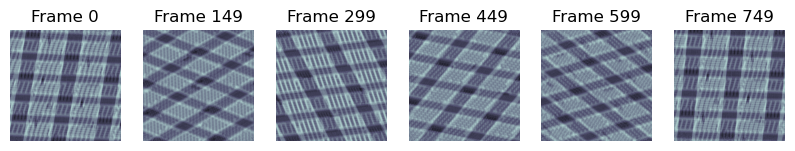

In [9]:
# Set the ROI for cross-correlation.
# The ROI should not contain edges of the sample.
wL = 32*30
lam.data.data.setXCorrROI(data, widths=[wL, wL])
%matplotlib inline
lam.data.data.plotSamples(imageStack=data.stackObject, 
                          imageFunc=np.angle,
                          N=6,
                          ROI=data.xCorrROI)

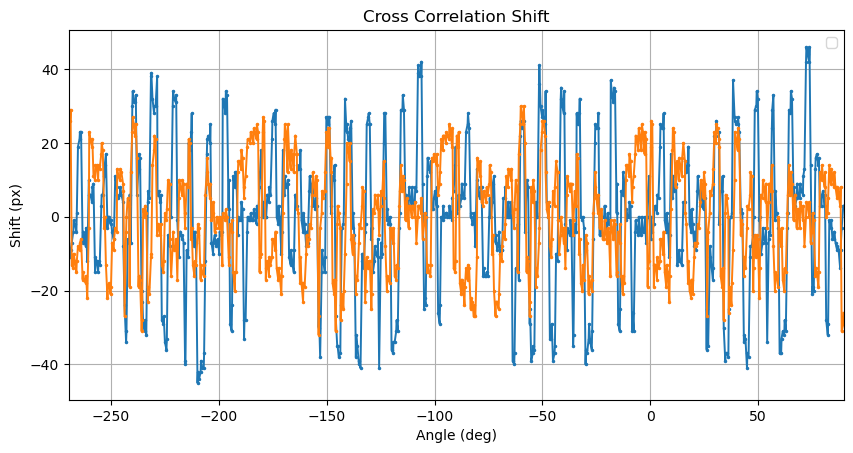

In [11]:
# Get the cross-correlation pre-alignment
%matplotlib inline
lam.data.data.crossCorrelationAlign(data)
lam.data.data.plotShift(data, [data.xCorrShift], 'Cross Correlation Shift')

In [12]:
# Apply the cross-correlation pre-alignment to the stackObject and weights
lam.utils.imShiftLinear(data.stackObject, data.xCorrShift);
lam.utils.imShiftLinear(data.weightSino, data.xCorrShift);

In [13]:
# Set the ROI that will be used in phase unwrapping
# Leaving the input empty means the entire stackObject range will be used
data.setObjectROI()

Object ROI: 
 - Vertical: 0 to 1599 
 - Horizontal: 0 to 2367


Single Frame Size: (1600, 2368) 
Number of Frames: 750


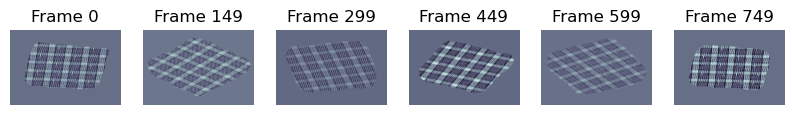

In [15]:
# Do 2D phase wrapping to get the sinogram
lam.data.data.unwrapPhase2D(data)
data.sinogram = -data.sinogram
%matplotlib inline
lam.data.data.plotSamples(data.sinogram, N=6)

In [19]:
data.setAlignmentROI()
data.reconstructionPrep()

Alignment ROI: 
 - Vertical: 0 to 1599 
 - Horizontal: 0 to 2367
Number of pixels in full resolution 3D reconstruction: [2464 2464  288] px
Pixel Size: 27.2 nm
Reconstruction dimensions: [67.1, 67.1, 7.8] um


In [28]:
CoROffset = data.updatedGeometry['CoROffset']
print("Center of rotation (CoR) offset from config file:", CoROffset)

Center of rotation (CoR) offset from config file: [120.26315789  52.        ]


Iteration 0: Max step size update: 0.8000 px

0.2774 s  Shift Sinogram and Weights
Too large angular jump for FBP weighting, assuming missing wedge tomo
0.0788 s  FBP: Apply Filter
0.0635 s  Astra: Create Geometry and Objects
0.0001 s  Astra: Create Algorithm
0.0353 s  Astra: Run Algorithm
0.0010 s  Astra: Retrieve Reconstruction
0.1001 s  FBP: Astra Reconstruct
0.0058 s  Apply Circular Mask
0.5341 s  TOTAL LOOP TIME
1.2732 s  Projection Matching Execution Time


<Figure size 640x480 with 0 Axes>

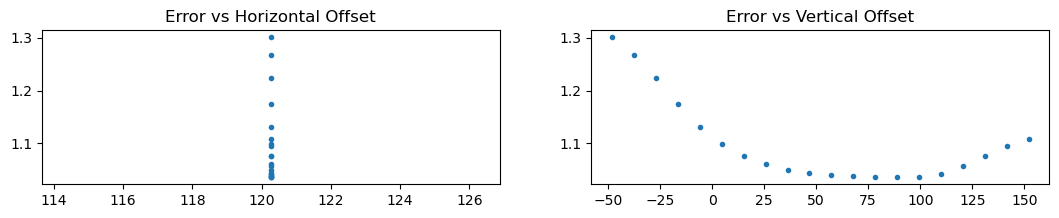

Estimated Center of Rotation (H,V): (120.3, 88.8)


In [30]:
# Estimate vertical center of rotation
%matplotlib inline
updateConfig = {'Estimate CoR': {'offsetCoR_V_center': CoROffset[1],
                                 'offsetCoR_V_range': 200,
                                 'offsetCoR_V_iterations': 20,
                                 'offsetCoR_H_center': CoROffset[0],
                                 'offsetCoR_H_range': 0,
                                 'offsetCoR_H_iterations': 1}}
CoROffset = lam.data.data.estimateCoROffset(data, updateConfig)

Iteration 0: Max step size update: 0.4409 px

0.2779 s  Shift Sinogram and Weights
Too large angular jump for FBP weighting, assuming missing wedge tomo
0.0966 s  FBP: Apply Filter
0.0638 s  Astra: Create Geometry and Objects
0.0001 s  Astra: Create Algorithm
0.0353 s  Astra: Run Algorithm
0.0011 s  Astra: Retrieve Reconstruction
0.1003 s  FBP: Astra Reconstruct
0.0072 s  Apply Circular Mask
0.5535 s  TOTAL LOOP TIME
1.2831 s  Projection Matching Execution Time


<Figure size 640x480 with 0 Axes>

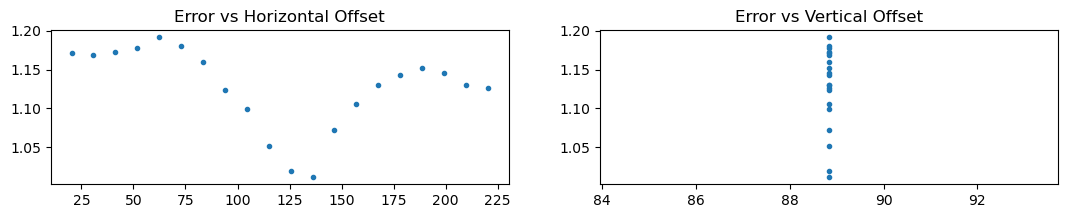

Estimated Center of Rotation (H,V): (136.1, 88.8)


In [32]:
# Estimate horizontal center of rotation
%matplotlib inline
updateConfig = {'Estimate CoR': {'offsetCoR_V_center': CoROffset[1],
                                 'offsetCoR_V_range': 0,
                                 'offsetCoR_V_iterations': 1,
                                 'offsetCoR_H_center': CoROffset[0],
                                 'offsetCoR_H_range': 200,
                                 'offsetCoR_H_iterations': 20}}
# Change the parameters manually to zero in on the CoR that minimizes error
CoROffset = lam.data.data.estimateCoROffset(data, updateConfig)

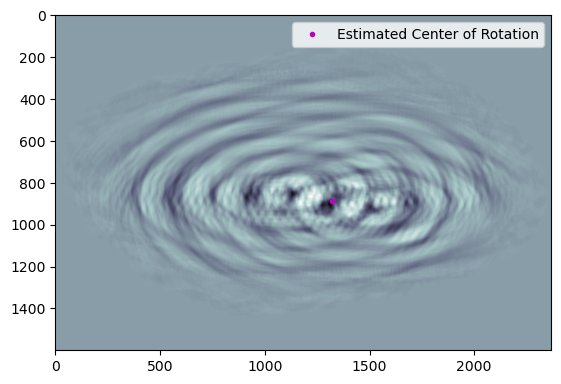

In [61]:
# Roughly check that the CoR is actually around the center
plotImage(data.sinogram.sum(axis=0))
CoR = np.array(data.sinogram.shape[1:])/2 + CoROffset[::-1]
plt.plot(CoR[1], CoR[0], '.m', label='Estimated Center of Rotation')
plt.legend()

In [67]:
# Update the center of rotation offset
data.updatedGeometry['CoROffset'] = np.array(CoROffset)
print("New CoR Offset:", CoROffset)

New CoR Offset: (136.0526315789474, 88.84210526315792)


In [ ]:
data.saveAll("cSAXS_exampleScript_beforePMA")

In [4]:
# # Reload data if necessary
# loadFolder = os.path.join(saveFolder, "data objects", "cSAXS_exampleScript_beforePMA")
# data = lam.data.data(reload=True,
#                     loadFolder=loadFolder,
#                     loadStackObject=True)

In [97]:
# Set ROI that will be used in alignment
data.setAlignmentROI()  # omit inputs to use full range
# Calculate the number of pixels that will be in the full-resolution
# reconstruction for the specified ROI
data.reconstructionPrep()

Alignment ROI: 
 - Vertical: 0 to 1599 
 - Horizontal: 0 to 2367
Number of pixels in full resolution 3D reconstruction: [2464 2464  288] px
Pixel Size: 27.2 nm
Reconstruction dimensions: [67.1, 67.1, 7.8] um


In [ ]:
%matplotlib inline
# Override settings from config file
updateConfig = {'Projection Matching': {'binningArray': [32, 16, 8, 4, 2],
                                        'maxIter': 300,
                                        'minStepSize': 0.01}}
# WhichPlots determines what kinds of movies will be saved
whichPlots = {'incremental shifts 0': False,
              'incremental shifts 1': False,
              'cumulative shifts 0': True,
              'cumulative shifts 1': True,
              'reconstruction': True,
              'aligned sinogram': True,
              'model sinogram': True,
              'initial sinogram': True,
              'weighted initial sinogram': False}
# Run the projection-matching alignment sequence
lam.data.data.runReconstructionSequence(
    data,
    folder=data.folders['alignment results'],
    updateConfig=updateConfig,
    saveData='all',
    whichPlots=whichPlots
)
%matplotlib inline

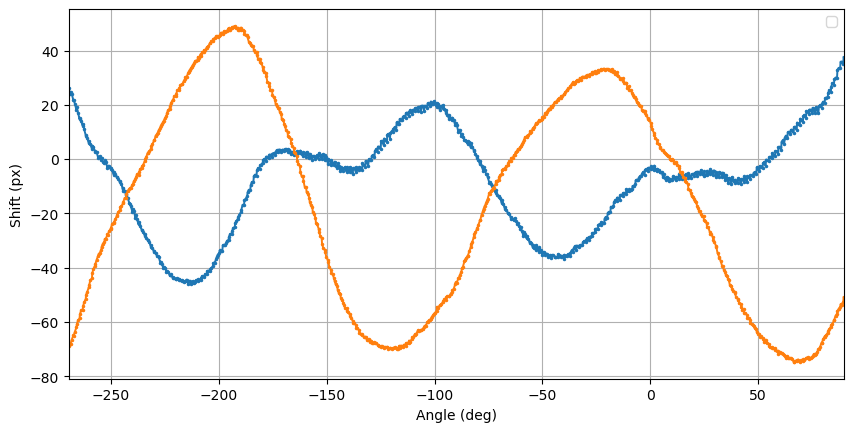

In [121]:
# Plot the alignment shift as of this point
%matplotlib inline
data.plotShift([data.projMatch.shiftTotal])
plt.show()

In [ ]:
data.saveAll("cSAXS_exampleScript_2xAligned")

In [140]:
# # Reload data if necessary
# loadFolder = os.path.join(saveFolder, "data objects", "cSAXS_exampleScript_2xAligned")
# data = lam.data.data(reload=True,
#                     loadFolder=loadFolder,
#                     loadStackObject=True)

In [142]:
# Decrease the alignment ROI for the high-resolution alignment
# Must be done because otherwise GPUs can't hold all the data
data.setAlignmentROI([900, 1400])
data.reconstructionPrep()

Alignment ROI: 
 - Vertical: 352 to 1247 
 - Horizontal: 512 to 1855
Number of pixels in full resolution 3D reconstruction: [1408 1408  288] px
Pixel Size: 27.2 nm
Reconstruction dimensions: [38.3, 38.3, 7.8] um


In [ ]:
# Run at high resolution
# Note that the stepRelaxation value must often be increased at the end of the alignment
%matplotlib inline
# Override settings from config file
updateConfig = {'Projection Matching': {'binningArray': [1],
                                        'maxIter': 300,
                                        'stepRelaxation': 0.5,  # Increased from initial value
                                        'minStepSize': 0.01}}
whichPlots = {'incremental shifts 0': False,
              'incremental shifts 1': False,
              'cumulative shifts 0': True,
              'cumulative shifts 1': True,
              'reconstruction': True,
              'aligned sinogram': True,
              'model sinogram': True,
              'initial sinogram': True,
              'weighted initial sinogram': False}
# Run the projection-matching alignment sequence
lam.data.data.runReconstructionSequence(
    data,
    folder=data.folders['alignment results'],
    updateConfig=updateConfig,
    saveData='all',
    whichPlots=whichPlots,
    shifts=data.projMatch.shiftTotal*1  # Initialize with the shift from the previous alignment
)
%matplotlib inline

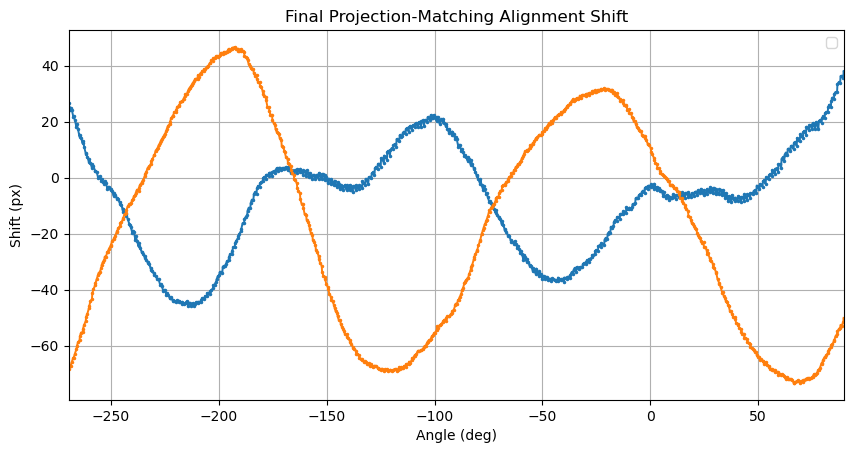

In [156]:
data.plotShift([data.projMatch.shiftTotal], title="Final Projection-Matching Alignment Shift")

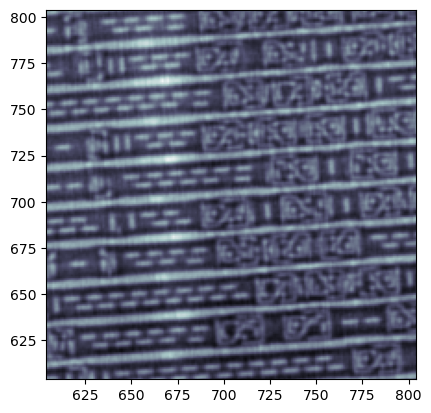

In [153]:
# Plot a slice of the final reconstruction
plotImage(data.projMatch.rec[217], 200)
plt.show()

In [ ]:
data.saveAll("exampleScript_cSAXS_completedPMA")

In [269]:
# # Reload data if necessary
# loadFolder = os.path.join(saveFolder, "data objects", "exampleScript_cSAXS_completedPMA")
# data = lam.data.data(reload=True,
#                     loadFolder=loadFolder,
#                     loadStackObject=True)

In [345]:
# Apply the PMA shift to the sinogram and weights
data.sinogram = lam.data.data.fftImShiftStack(data.sinogram, data.projMatch.shiftTotal)
data.weightSino = lam.data.data.fftImShiftStack(data.weightSino, data.projMatch.shiftTotal)

In [271]:
# The alignment ROI is the region used in the final 3D reconstruction (the name is a misnomer in this case, I know)
# Re-set the alignment ROI to be the entire sinogram
data.setAlignmentROI()  # When there are no arguments, the alignment ROI will be the full sinogram range
data.reconstructionPrep()  # Calculate the number of pixels (data.NpixAlign) to be used in the reconstruction

Alignment ROI: 
 - Vertical: 0 to 1599 
 - Horizontal: 0 to 2367
Number of pixels in full resolution 3D reconstruction: [2464 2464  288] px
Pixel Size: 27.2 nm
Reconstruction dimensions: [67.1, 67.1, 7.8] um


In [272]:
# Get the 3D reconstruction and store in data.tomogram
data.astraReconstruct();

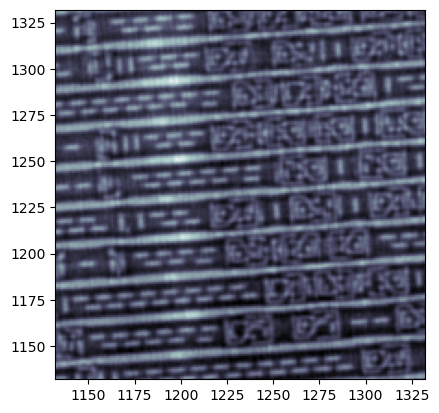

In [273]:
# Plot one slice of the reconstruction
plotImage(data.tomogram[217], 200)
plt.clim([-0.012, 0.024])
plt.show()

In [274]:
# Get angles to rotate the reconstruction by
data.getRotationAngles()
# Rotate the reconstruction
data.rotateTomogram()

Rotation angles stored in tomoRotAngles:  [ 0.04509018 -0.12427054  4.19338677]
tomogram rotated by [ 0.04509018 -0.12427054  4.19338677] 
Rotated tomogram is stored in tomogram_rot


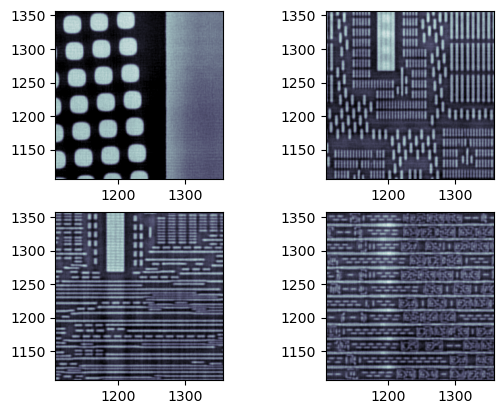

In [275]:
# Plot a few slices of the rotated reconstruction
clim = [-0.012, 0.024]
fig, ax = plt.subplots(2, 2)
w = 250
plotImage(data.tomogram_rot[100], w, ax=ax[0, 0]).clim(clim)
plotImage(data.tomogram_rot[188], w, ax=ax[0, 1]).clim(clim)
plotImage(data.tomogram_rot[204], w, ax=ax[1, 0]).clim(clim)
plotImage(data.tomogram_rot[217], w, ax=ax[1, 1]).clim(clim)
plt.show()

In [ ]:
# Save the final result in a data object
data.saveAll("cSAXS_exampleScript_final")

In [443]:
# Save as tiff
lam.data.data.saveAsTiff(data, "cSAXS_final_reconstruction.tiff")

In [ ]:
# Save as .vti file (can be opened in Paraview)
lam.data.data.saveAsVTI(data, "cSAXS_final_reconstruction.vti")

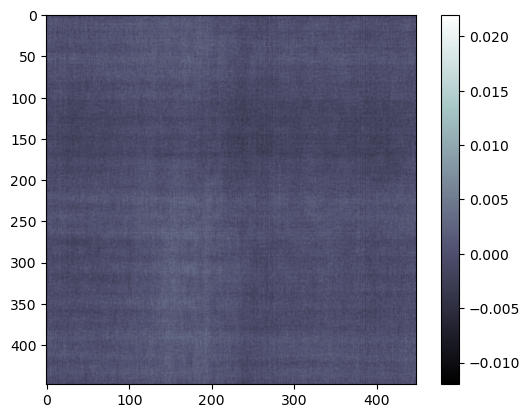

In [240]:
# Save a subset of the reconstruction as an mp4 and a folder of individual .png files
centers = (np.array(data.tomogram_rot.shape[1:])/2).astype(int)
width = 500
tomoROI = data.setGeneralROI(data.tomogram_rot.shape[1:],
                             [width, width],
                             centers)
tomoSubset = data.tomogram_rot[:, tomoROI[0]][:, :, tomoROI[1]]
plotImage(tomoSubset[230])
plt.clim([-0.012, 0.022])
plt.colorbar()

movieFolder = os.path.join(data.folders['parent'], "movies")
if not os.path.isdir(movieFolder):
    os.makedirs(movieFolder)

filename = os.path.join(movieFolder, "reconstruction_width500_DPI200_FPS15")
FPS = 15
clim = [-0.012, 0.022]
lam.plotting.animateStack(
    tomoSubset,
    title="",
    filename=filename,
    FPS=FPS,
    DPI=200,
    plotType='mp4',
    clim=clim)